# Sistemas de Recomendação - Método 01

Neste notebook vamos desenvolver um simples sistema de recomendação usando Python, Pandas e Scikit Learn. Nosso objetivo é desenvolver um sistema um sistema basico capaz de realizar sugestões de filmes baseados nas avaliações dos usuários.

Para esse exemplo usaremos o arquivo `ml-latest-small.zip`, o qual contêm um conjunto de dados reduzido.

------
## Importa Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Os dados utilizados são provenientes da plataforma [MovieLens](https://grouplens.org/datasets/movielens/). Primeiramente vamos entender o conteúdo dos dados no arquivo `ratings.csv` responsávle por armazenar as notas dos usuários.

In [2]:
df_notas = pd.read_csv('../datasets/ml-latest-small/ratings.csv')

In [3]:
df_notas.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Agora vamos explorar o arquivo `movies.csv` o qual contem o nome e outras informações importantes dos filmes contidos na base de dados `ratings.csv`

In [4]:
df_filmes = pd.read_csv('../datasets/ml-latest-small/movies.csv')

In [5]:
df_filmes.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Vamos unir os dois dataframes utilizando a coluena `movieId`

In [6]:
df_notas = pd.merge(df_notas, df_filmes, on='movieId')

In [7]:
df_notas.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


--------
## Análise Exploratória dos Dados

Vamos realizar uma pequena análise exploratória dos dados para compreender melhor o seu conteudo.

### Agregação dos dados pela média

In [8]:
sns.set_style('white')

Inicialmente vamos agregar os filmes pelas médias de avaliações e número de avaliações realizadas.

In [9]:
df_notas.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

In [10]:
df_notas.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [11]:
notas = pd.DataFrame(df_notas.groupby('title')['rating'].mean())

In [12]:
notas['number of ratings'] = pd.DataFrame(df_notas.groupby('title')['rating'].count())

In [13]:
notas.sample(5)

,rating,number of ratings
title,,
I Love You Phillip Morris (2009),1.500000,2
Jim Jefferies: BARE (2014),4.500000,1
Shoot 'Em Up (2007),3.458333,12
Adam's Apples (Adams æbler) (2005),4.166667,3
Fever Pitch (1997),3.000000,2


### Histogramas 
Vamos examinar alguns histogramas acerca dos dados.

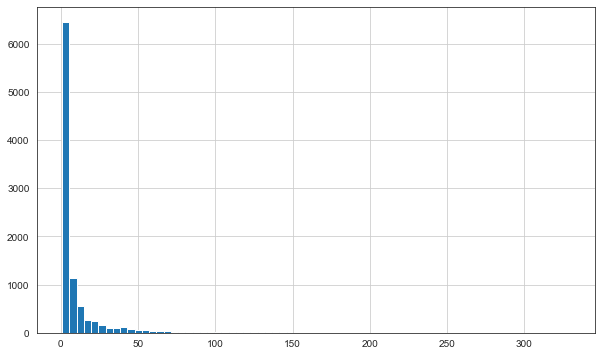

In [14]:
plt.figure(figsize=(10,6))
notas['number of ratings'].hist(bins=70)

Podemos observar que a grande maoria dos filmes tem uma baixa quantidade de avaliações.

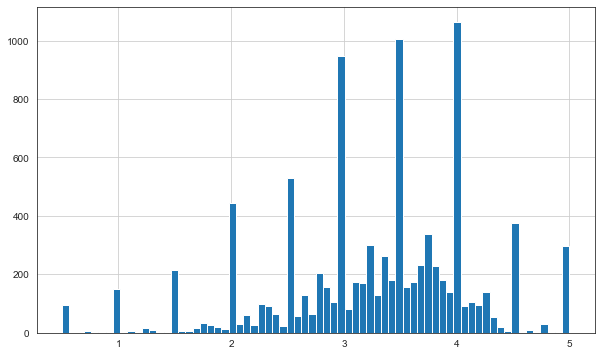

In [15]:
plt.figure(figsize=(10,6))
notas['rating'].hist(bins=70)

Observando o histograma das médias, observamos alguns _outlines_ ocasionados pela pequena quantidade de avaliações que alguns filmes possuem. Esses filmes possuem avaliações específicar em 5,4,3,2,1 estrelas, demonstrando que, possivelmente, poucos usuários os avaliaram.

C:\Users\Junior\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


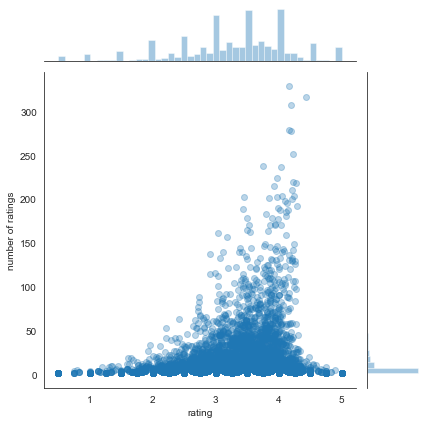

In [16]:
sns.jointplot(x='rating', y='number of ratings', data=notas, alpha=0.3)

Observando o jointplot notamos que normalmente a medida que aumenta o numero de avaliações, aumentam as notas.

------
## Sistemas de Recomendação

Vamos explorar a utilização de um sistema de recomendação para filmes baseada na classificação dada por outros usuários. Para uma comprenssão mais detalhada do seu funcioamento leia o artigo presente [neste link](https://www.ibm.com/developerworks/br/local/data/sistemas_recomendacao/index.html).

<img width='500px' src='https://www.ibm.com/developerworks/br/local/data/sistemas_recomendacao/image001_s.jpg' />

Quando trata-se de sistemas de recomendação podemos citar três tipos:
* **Baseado em Conteúdo:** O sistema recomenda ao usuário produtos que sejam semelhantes ao que ele preferiu no passado. Em um cenário de recomendação de filmes, por exemplo, um usuário que, assiste e gosta do filme "Matrix" teria recomendações do gênero ação e ficção científica.
* **Filtragem Colaborativa:** O sistema recomenda itens baseado em em gosto de outros usuários. A regra baseia-se em: "Se um usuário gostou de A e de B, um outro usuário que gostou de A também pode gostar de B"
* **Sistemas Hibrídos:** Consiste em um sistema que combina as duas abordagens mencionadas, tentando fortificá-las e superar suas desvantagens.

### Método 1

Vamos criar uma matriz que tenha os IDs de usuário em um eixo e o título dos filmes. Cada célula consistirá na classificação que o usuário atribuiu ao filme. Observe que haverá muitos valores de NaN, porque a maioria das pessoas não assistiu a todos os filmes.

In [17]:
moviemat = df_notas.pivot_table(index='userId', columns='title', values='rating')

In [18]:
moviemat.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para encontrar o filme baseado em uma palavra chave, foi elaborada a seguinte função:

In [19]:
def find_movie(keyword, df):
    """Find a movie based on keyword

    Parameters
    ----------
    kayword : str
        Keyword related to the movie

    df : Pandas DataFrame
        DataFrame containing the list of films

    Returns
    -------
        movies : Pandas Data Frame
            DataFrame with movies conteined keywors
    """
    
    movies = []
    
    for i in df['title']:
        if(i.find(keyword) != -1):
            movies.append(i)
    
    movies = pd.DataFrame(movies, 
                          columns='Filmes'.split())
    
    return movies

Para esse exemplo usaremos o filme **Star Wars Episodio IV**.

In [20]:
find_movie('Star Wars: Episode IV', df_filmes)

,Filmes
0,Star Wars: Episode IV - A New Hope (1977)


In [21]:
name_of_movie = 'Star Wars: Episode IV - A New Hope (1977)'
choose_movie = moviemat[name_of_movie]

Vamos identificar o número de avaliações que o filme star wars teve.

In [22]:
notas.loc[name_of_movie]

rating                 4.231076
number of ratings    251.000000
Name: Star Wars: Episode IV - A New Hope (1977), dtype: float64

Vamos encontrar os filmes similares ao escolhido baseado na opinião de outras pessoas.

In [23]:
similar_to_choose_movie = moviemat.corrwith(choose_movie)

C:\Users\Junior\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Junior\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [24]:
corr_choose_movie = pd.DataFrame(similar_to_choose_movie, columns=['Correlation'])
corr_choose_movie.dropna(inplace=True)

In [25]:
corr_choose_movie.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Lakeview Terrace (2008),1.0
Cry_Wolf (a.k.a. Cry Wolf) (2005),1.0
Creep (2014),1.0
Non-Stop (2014),1.0
Not Without My Daughter (1991),1.0
Confessions of a Teenage Drama Queen (2004),1.0
Concussion (2015),1.0
Opera (1987),1.0
Our Hospitality (1923),1.0


Classificando o DataFrame pela maior correlação, obtemos os filmes mais semelhantes; no entanto, observe que alguns resultados que realmente não fazem sentido. Isso ocorre porque há muitos filmes assistidos apenas uma vez por usuários que também assistiram star wars. Vamos corrigir isso filtrando os filmes com pelo menos de 100 avaliações (esse valor foi escolhido com base no histograma anterior).

In [26]:
corr_choose_movie = corr_choose_movie.join(notas['number of ratings'])

In [27]:
corr_choose_movie[corr_choose_movie['number of ratings'] > 100].sort_values('Correlation', 
                                                                            ascending=False).head(10)

,Correlation,number of ratings
title,,
Star Wars: Episode IV - A New Hope (1977),1.000000,251
Star Wars: Episode V - The Empire Strikes Back (1980),0.777970,211
Star Wars: Episode VI - Return of the Jedi (1983),0.734230,196
"Fugitive, The (1993)",0.482078,190
Indiana Jones and the Last Crusade (1989),0.410916,140
"Lord of the Rings: The Return of the King, The (2003)",0.406602,185
Ghostbusters (a.k.a. Ghost Busters) (1984),0.391613,120
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),0.384779,200
"Godfather, The (1972)",0.365920,192


Podemos observar que as pessoas que assistiram Star Wars Episodio I tendem a gostar dos demais filmes da franquia, o que faz sentido.